# $\tau$ VS $\eta$ (standard deviation of the Gaussian kernel versus normalized cut-off frequency)


Replicar esto, pero usando w1, h1 = signal.freqz(kernel[0], fs=10000)


/tmp/ipykernel_45629/112769998.py:57: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freqs, 20 * np.log10(response))


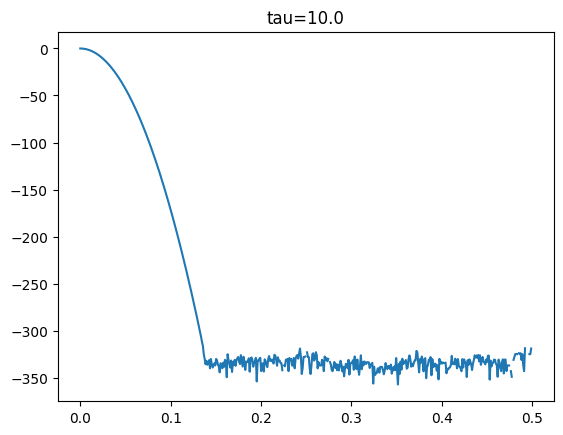

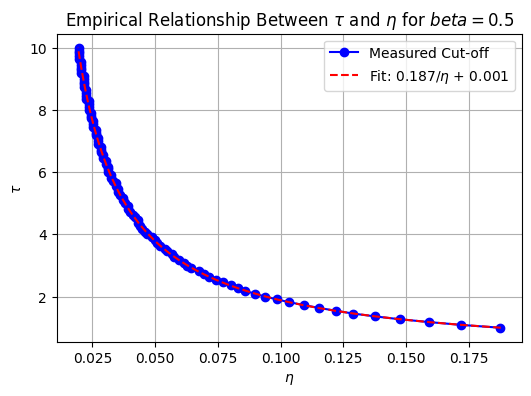

Empirical formula: f_c^* ≈ 0.187 / sigma + 0.001


In [54]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from scipy import signal
from denoising.utils import get_gaussian_kernel

# Define parameters
beta = 0.5 # 1/np.sqrt(2)
sigma_values = np.linspace(1, 10, 100)  # Range of sigma values to test
#sigma_values = np.linspace(0.5, 0.5, 1)  # Range of sigma values to test
bandwidth=1
normalized_cutoff_freqs = []

def naive_gaussian_kernel(sigma=1, k=20):
    """Generates a truncated Gaussian kernel without smoothing adjustments."""
    L = 2 * k * sigma + 1  # Ensure an odd length
    x = np.arange(-L//2, L//2 + 1)
    kernel = np.exp(-0.5 * (x / sigma) ** 2)
    return kernel / kernel.sum()  # Normalize

for sigma in sigma_values:
    #print("sigma =", sigma)
    # Generate Gaussian kernel
    kernel = naive_gaussian_kernel(sigma)
    #kernel = get_gaussian_kernel(sigma)
    #print(kernel.shape)
    #plt.plot(kernel)
    #plt.show()

    # Compute its frequency response
    freqs, response = signal.freqz(kernel, fs=bandwidth)
    response = np.abs(response)
    #plt.plot(freqs, response)
    #plt.show()

    # Find the effective cut-off frequency (where magnitude falls below ~0.707)
    #cutoff_idx = np.where(response < 1 / np.sqrt(2))[0][0]
    #map = np.asarray(response < 1 / np.sqrt(2)).nonzero()
    #print(np.min(response))
    map = np.asarray(response < beta).nonzero()
    #print(map)
    try:
        cutoff_idx = map[0][0]  # The first element of a list of arrays with only one array
    except IndexError:
        cutoff_idx = 511
    #cutoff_idx = np.where(response < response[0] / np.sqrt(2))[0][0]
    #print(response[0] / 10)
    
    #cutoff_idx = np.where(response < response[0] / 10)[0][0]
    #print("freq_response[0]=", freq_response[0])
    #cutoff_idx = np.where(freq_response < 1.4)[0][0]
    #print("cutoff_idx=", cutoff_idx)
    cutoff_freq = freqs[cutoff_idx]/bandwidth
    normalized_cutoff_freqs.append(cutoff_freq)
plt.title(f"tau={sigma}")
#plt.plot(freqs, response)
plt.plot(freqs, 20 * np.log10(response))
plt.show()

# Fit an empirical formula: f_c^* ≈ C / sigma
coeff = np.polyfit(1 / sigma_values, normalized_cutoff_freqs, 1)

# Display empirical relationship
plt.figure(figsize=(6, 4))
#plt.plot(sigma_values, normalized_cutoff_freqs, 'bo-', label='Measured Cut-off')
plt.plot(normalized_cutoff_freqs, sigma_values, 'bo-', label='Measured Cut-off')
#plt.plot(sigma_values, coeff[0] * (1 / sigma_values) + coeff[1], 'r--', label=f'Fit: {coeff[0]:.3f}/sigma + {coeff[1]:.3f}')
plt.plot(coeff[0] * (1 / sigma_values) + coeff[1], sigma_values, 'r--', label=rf'Fit: {coeff[0]:.3f}/$\eta$ + {coeff[1]:.3f}')
plt.ylabel(r"$\tau$")
plt.xlabel(r"$\eta$")
plt.legend()
plt.title(rf"Empirical Relationship Between $\tau$ and $\eta$ for $beta={beta}$")
plt.grid()
plt.show()

print(f"Empirical formula: f_c^* ≈ {coeff[0]:.3f} / sigma + {coeff[1]:.3f}")


In [8]:
import numpy as np
import math

# Given parameters
tau = 5
beta = 0.1

# Compute continuous cutoff frequency
eta = np.sqrt(-2 * np.log(beta)) / tau
hat_eta = eta/200
hat_eta

np.float64(0.002145966026289347)

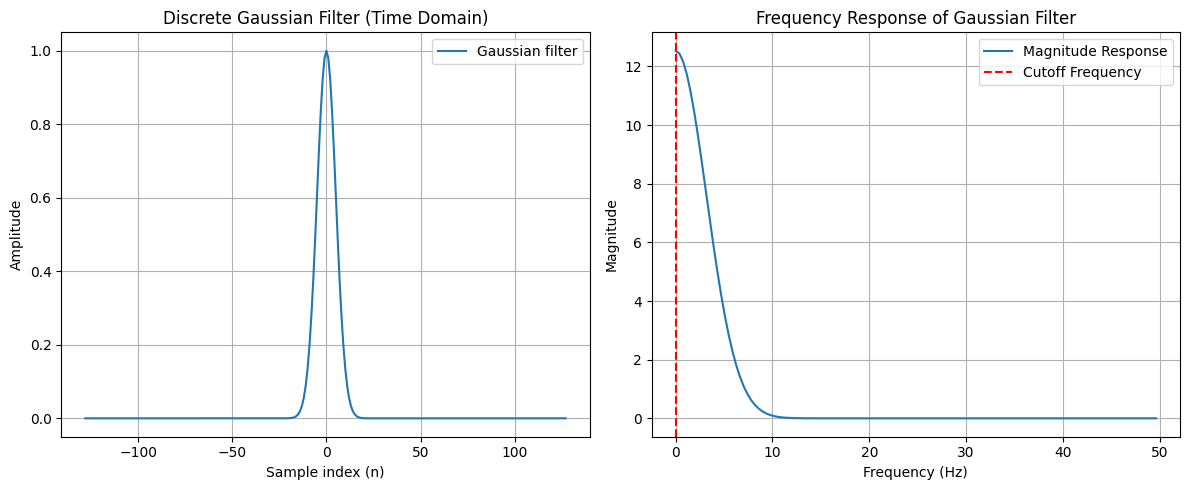

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

# Given parameters
tau = 5
fs = 100  # Sampling frequency
N = 256  # Length of the filter

# Generate Gaussian filter in discrete-time
n = np.arange(-N//2, N//2)  # Centered indices
h = np.exp(-n**2 / (2 * tau**2))  # Gaussian function

# Compute frequency response
H = np.abs(fft(h))  # Magnitude spectrum
freqs = fftfreq(N, d=1/fs)  # Frequency axis

# Compute cutoff frequency
eta = np.sqrt(-2 * np.log(0.1)) / tau
eta_discrete = (eta / (2 * np.pi * fs)) * np.pi  # Discrete cutoff frequency

# Plot time-domain Gaussian filter
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n, h, label="Gaussian filter")
plt.xlabel("Sample index (n)")
plt.ylabel("Amplitude")
plt.title("Discrete Gaussian Filter (Time Domain)")
plt.legend()
plt.grid()

# Plot frequency response
plt.subplot(1, 2, 2)
plt.plot(freqs[:N//2], H[:N//2], label="Magnitude Response")
plt.axvline(eta / (2 * np.pi), color='r', linestyle='--', label="Cutoff Frequency")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Response of Gaussian Filter")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from denoising.utils import get_gaussian_kernel

# Define parameters
sigma_values = np.linspace(0.5, 10, 100)  # Range of sigma values to test
N = 256  # Signal length
normalized_cutoff_freqs = []

for sigma in sigma_values:
    # Generate Gaussian kernel
    kernel = get_gaussian_kernel(sigma)

    # Compute its frequency response
    freq_response = np.abs(np.fft.fft(kernel, N))  # Compute FFT
    freq_response = freq_response[:N//2]  # Take only the first half (positive frequencies)
    freq_axis = np.linspace(0, 0.5, N//2)  # Normalized frequency axis (Nyquist = 0.5)

    # Find the effective cut-off frequency (where magnitude falls below ~0.707)
    cutoff_idx = np.where(freq_response < freq_response[0] / np.sqrt(2))[0][0]
    #print("freq_response[0]=", freq_response[0])
    #cutoff_idx = np.where(freq_response < 1.4)[0][0]
    #print("cutoff_idx=", cutoff_idx)
    cutoff_freq = freq_axis[cutoff_idx]
    normalized_cutoff_freqs.append(cutoff_freq)

# Fit an empirical formula: f_c^* ≈ C / sigma
coeff = np.polyfit(1 / sigma_values, normalized_cutoff_freqs, 1)

# Display empirical relationship
plt.figure(figsize=(6, 4))
plt.plot(sigma_values, normalized_cutoff_freqs, 'bo-', label='Measured Cut-off')
plt.plot(sigma_values, coeff[0] * (1 / sigma_values) + coeff[1], 'r--', label=f'Fit: {coeff[0]:.3f}/sigma + {coeff[1]:.3f}')
plt.xlabel("Sigma")
plt.ylabel(r"Effective Normalized Cut-off Frequency ($f_c^*$)")
plt.legend()
plt.title("Empirical Relationship Between Sigma and Cut-off Frequency")
plt.grid()
plt.show()

print(f"Empirical formula: f_c^* ≈ {coeff[0]:.3f} / sigma + {coeff[1]:.3f}")


In [ ]:
def normalized_cutoff_to_tau(cutoff_freq):
    tau = 0.141 / cutoff_freq
    return tau

In [ ]:
tau = normalized_cutoff_to_tau(0.25)
tau

In [ ]:
import math
math.sqrt(2)

In [ ]:
np.sqrt(2)

In [ ]:
math.sqrt(-2*math.log(0.956))

In [ ]:
math.log(math.exp(10))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

# Given parameters
tau = 5
fs = 100  # Sampling frequency
N = 256  # Length of the filter

# Generate Gaussian filter in discrete-time
n = np.arange(-N//2, N//2)  # Centered indices
h = np.exp(-n**2 / (2 * tau**2))  # Gaussian function

# Compute frequency response
H = np.abs(fft(h))  # Magnitude spectrum
freqs = fftfreq(N, d=1/fs)  # Frequency axis

# Compute cutoff frequency
eta = np.sqrt(-2 * np.log(0.1)) / tau
#eta_discrete = (eta / (2 * np.pi * fs)) * np.pi  # Discrete cutoff frequency
eta_discrete = (eta / (2 * fs))  # Discrete cutoff frequency

# Plot time-domain Gaussian filter
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n, h, label="Gaussian filter")
plt.xlabel("Sample index (n)")
plt.ylabel("Amplitude")
plt.title("Discrete Gaussian Filter (Time Domain)")
plt.legend()
plt.grid()

# Plot frequency response
plt.subplot(1, 2, 2)
plt.plot(freqs[:N//2], H[:N//2], label="Magnitude Response")
plt.axvline(eta / (2 * np.pi), color='r', linestyle='--', label="Cutoff Frequency")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Response of Gaussian Filter")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [27]:
np.sqrt(-np.log(0.5))/(2*np.pi)

np.float64(0.13250518175969844)

In [26]:
math.sqrt(math.log(2))/(2*math.pi)

0.13250518175969844

In [29]:
np.sqrt(np.log(2))

np.float64(0.8325546111576977)

In [30]:
np.sqrt(np.log(2)) / (np.pi*2)

np.float64(0.13250518175969844)

In [31]:
0.832555 / 6.283185

0.13250525012394193

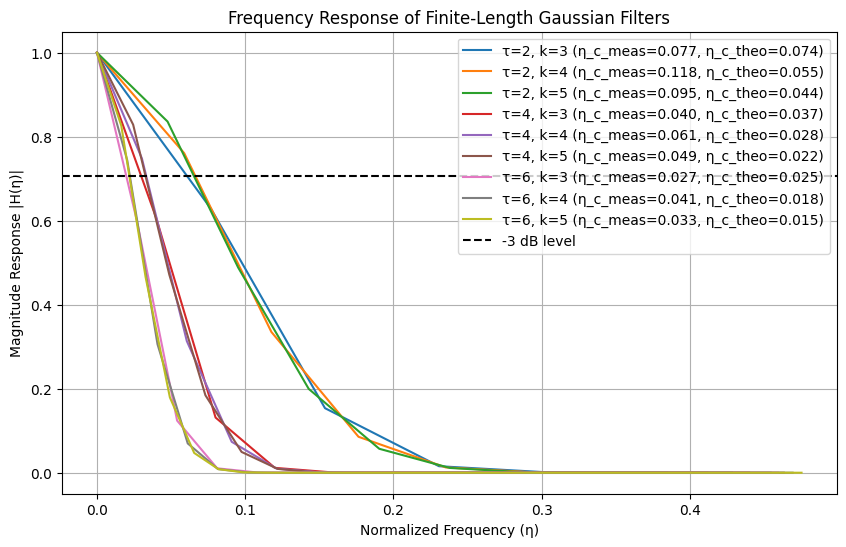

{(2, 3): (np.float64(0.07692307692307693),
  0.07383333333333333,
  13,
  array([0.0022182 , 0.00877313, 0.02702316, 0.06482519, 0.12110939,
         0.17621312, 0.19967563, 0.17621312, 0.12110939, 0.06482519,
         0.02702316, 0.00877313, 0.0022182 ]),
  array([0.        , 0.07692308, 0.15384615, 0.23076923, 0.30769231,
         0.38461538]),
  array([1.00000000e+00, 6.28351008e-01, 1.53690575e-01, 1.55032854e-02,
         1.98214003e-04, 2.14303594e-04])),
 (2, 4): (np.float64(0.11764705882352941),
  0.055375,
  17,
  array([6.69162896e-05, 4.36349021e-04, 2.21596317e-03, 8.76430436e-03,
         2.69959580e-02, 6.47599366e-02, 1.20987490e-01, 1.76035759e-01,
         1.99474648e-01, 1.76035759e-01, 1.20987490e-01, 6.47599366e-02,
         2.69959580e-02, 8.76430436e-03, 2.21596317e-03, 4.36349021e-04,
         6.69162896e-05]),
  array([0.        , 0.05882353, 0.11764706, 0.17647059, 0.23529412,
         0.29411765, 0.35294118, 0.41176471]),
  array([1.00000000e+00, 7.60965649e-0

In [33]:
# Re-import necessary libraries after execution state reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
#from scipy.signal import gaussian
from scipy.signal.windows import gaussian

def compute_cutoff_frequency(tau, k, fs=1.0):
    """
    Compute the cutoff frequency (-3 dB point) of a finite-length Gaussian filter.
    
    Parameters:
        tau: Standard deviation of the Gaussian kernel
        k: Truncation factor (Gaussian is truncated at ±k*tau)
        fs: Sampling frequency (default=1 for normalized frequency)

    Returns:
        Measured cutoff frequency eta_c
    """
    # Define kernel length
    L = int(2 * k * tau + 1)
    if L % 2 == 0:
        L += 1  # Ensure odd length for symmetry

    # Generate discrete Gaussian kernel
    kernel = gaussian(L, std=tau, sym=True)
    kernel /= np.sum(kernel)  # Normalize

    # Compute frequency response via FFT
    freq = fftfreq(L, d=1/fs)[:L//2]  # Positive frequencies
    response = np.abs(fft(kernel))[:L//2]
    response /= np.max(response)  # Normalize magnitude

    # Find cutoff frequency (-3 dB point, |H(f)| = 1/sqrt(2))
    idx_cutoff = np.where(response <= 1/np.sqrt(2))[0][0]
    eta_c_measured = freq[idx_cutoff]  # Normalized cutoff frequency

    return eta_c_measured, freq, response, L, kernel

# Define tau and k
tau_values = [2, 4, 6]
k_values = [3, 4, 5]
results = {}

for tau in tau_values:
    for k in k_values:
        eta_c_measured, freq, response, L, kernel = compute_cutoff_frequency(tau, k)
        eta_c_theoretical = 0.443 / (k * tau)
        results[(tau, k)] = (eta_c_measured, eta_c_theoretical, L, kernel, freq, response)

# Plot results for different tau and k values
plt.figure(figsize=(10, 6))
for (tau, k), (eta_c_measured, eta_c_theoretical, L, kernel, freq, response) in results.items():
    plt.plot(freq, response, label=f"τ={tau}, k={k} (η_c_meas={eta_c_measured:.3f}, η_c_theo={eta_c_theoretical:.3f})")

plt.axhline(1/np.sqrt(2), color="black", linestyle="--", label="-3 dB level")
plt.xlabel("Normalized Frequency (η)")
plt.ylabel("Magnitude Response |H(η)|")
plt.title("Frequency Response of Finite-Length Gaussian Filters")
plt.legend()
plt.grid()
plt.show()

# Print numerical results
results